<a href="https://colab.research.google.com/github/IHMilon/CNN-Image-Classification-Portfolio/blob/main/VGG11_CIFAR10/ResNet_on_CIFAR100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ResNet on CIFAR-100**

In this project, we implement and train a **Residual Neural Network (ResNet)** on the **CIFAR-100 dataset**.  
The goal is to explore the effectiveness of deep residual learning in classifying 100 object categories.

---

## Overview
- **Dataset**: CIFAR-100 (60,000 images, 32×32, 100 classes)  
- **Architecture**: ResNet inspired custom model.  
- **Framework**: PyTorch  
- **Objective**: Image classification with high accuracy using deep residual connections

## **Install Required Package**

In [ ]:
!pip install torchprofile 1>/dev/null

## **Import Libraries**

In [ ]:
import random
import time
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchprofile import profile_macs
from sklearn.metrics import confusion_matrix
from collections import namedtuple
from PIL import Image

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.amp import autocast, GradScaler
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import OneCycleLR

## **Setting Seed_value**

In [ ]:
seed = 40
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

## **Set Device**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device is : {device}")

Device is : cpu


## **Images Transformation**
I apply Data Transformation to increase the size of training data as **CIFAR100** has 600 images per class. It will also improve the model performance and generalization.

In [ ]:
train_transforms = transforms.Compose([
      transforms.RandomCrop(32, padding = 4),
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(10),
      #transforms.RandomErage(p = 0.3),
      transforms.ToTensor()
      ])

test_transforms = transforms.Compose([
      transforms.ToTensor()
      ])

## **Load the Dataset**
We use the pytorch torchvision dataset. Which contains 60,000 (32, 32) color images. Where,
- **Training data :** 50,000 images are used for training.
- **Test data :** 10,000 images are used for testing.

There are total 100 classes and each one contains 600 images. Batch size is kept little bit of higher to make the learning.

In [ ]:
# Prepare Training set
train_set = datasets.CIFAR100(root = "data/cifar100", train = True, download= True, transform = train_transforms)
train_loader = DataLoader(train_set, batch_size = 256, shuffle = True, pin_memory = True)

# Prepare Test set
test_set = datasets.CIFAR100(root = "data/cifar100", train = False, download = True, transform = test_transforms)
test_loader = DataLoader(test_set, batch_size = 128, shuffle = False, pin_memory = True)

## **Inspect the proper Batch loading**

In [ ]:
train_batch = next(iter(train_loader))
images, targets = train_batch
print(f"Images shape : {images.shape}, and dtype : {images.dtype}")
print(f"Targets shape : {targets.shape}, and dtype : {targets.dtype}")

Images shape : torch.Size([256, 3, 32, 32]), and dtype : torch.float32
Targets shape : torch.Size([256]), and dtype : torch.int64


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


### **Visualize prepared training images**

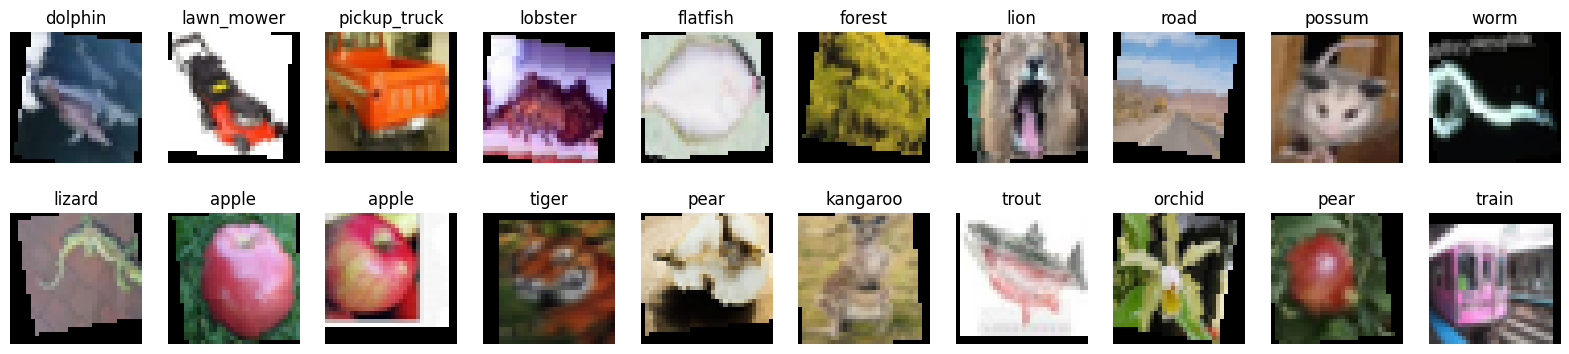

In [ ]:
plt.figure(figsize = (20,9))
for i in range (20):
    image = images[i]
    label = targets[i]

    class_name = train_set.classes[label]
    # Convert CHW to HWC
    image = image.permute(1,2,0).numpy()

    plt.subplot(4, 10, i+1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis("off")
plt.show()

## **Define the ResNet Inspired Model**

In [ ]:
# Build the Block
class BasicBlock(nn.Module):
    def __init__(in_channel,out_channel):
        super().__init__()

        self.in_cnannel = in_channel
        self.out_channel = out_channel

        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size = 3, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size = 3, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channle)

        self.relu = nn.ReLU(inplace = True)

        self.skip = nn.Sequential(
                    nn.Conv2d(in_channel, out_channel, kernel_size = 1, bias = False),
                    nn.BatchNorm2d(out_channel)
                    )

    def forward(self, x):
        skip = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.in_channle != self.out_channel:
            skip = self.skip(x)
        else:
            skip = skip

        # Skip Connection
        out += skip
        out = self.relu(out)
        return out

In [ ]:
class Resnet(nn.Module):
    def __init__( ):
        super().__init__()

        self.conv = nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3, bias = False )
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.layer1 = make_layer(in_channel, out_channel, n_blocks = 2)

    def make_layer(in_channel, out_channel, n_blocks):
        layer = []
        for _ in range (n_block):
            layer.append(Block(in_channel, out_channel))

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)

In [ ]:
ResNetConfig = namedtuple("ResNetConfig",["block", "n_blocks", "channels"])

In [ ]:
resnet18_config = ResNetConfig(block = BasicBlock,
                        n_blocks = [2,2,2,2],
                        channels = [64, 128, 256, 512])

In [ ]:
class Resnet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()

        block, n_blocks, channels = config
        self.in_channel = channel[0]

        assert len(n_blocks) == len(channels) == 4

        self.conv = nn.Conv2d(3, self.in_channel, kernel_size = 7, stride = 2, padding = 3, bias = False )
        self.bn = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.layer1 =

    def make_layer(self, n_blocks, channels, stride = 1):

        layers = []
        for _ in range(n_blocks):
            J

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.